In [5]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks_cwt
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import distance_metrics

In [6]:
distance_metrics()

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, *, sum_over_features=True)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, *, sum_over_features=True)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, *, sum_over_features=True)>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

In [20]:
class ILS():
    """ Iterative Label Spreading
    
    Parameters
    ----------
    
    n_clusters : int, default=None
        The number of clusters expected to be identified 
        from given dataset.
    
    min_cluster_size : int, default=None
        The minimum number of data points to be considered as a cluster.
    
    metric : String, default='euclidean'
        The valid metric for pairwise_distance.
        Must be a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS or
        an option allowed by scipy.spatial.distance.pdist
        
    Attributes
    ----------
    
    dataset : ndarray of shape(n_samples, n_features)
        Transform input dataset into numpy ndarray
        
    rmin : ndarray of shape(n_samples, )
        The R_min distance of each iteration
    
    Examples
    ---------
    ##to be added after implementation of find peaks algorithm
    
    """
    def __init__(self, n_clusters = None, min_cluster_size = None, metric = 'euclidean'):
        
        self.n_clusters = n_clusters # need to calculate defaults based on data set input
        self.min_cluster_size = min_cluster_size
        self.metric = metric
        
    def fit(self, X):
        
        if self.min_cluster_size is None: # added just so that it will run, but need to decide on better default
            self.min_cluster_size = int (0.1 * X.shape[0])
        
        self.data_set = np.concatenate((np.array(X), np.zeros((X.shape[0],2))), axis = 1)
        self.rmin = []
        
        self.data_set[0, X.shape[1]] = 1 #initialise first label
        unlabelled = [i + 1 for i in range(X.shape[0] - 1)] # step 1
        label_spreading = self.label_spreading([0], unlabelled)
        
        new_centers, new_unlabelled = self.find_initial_points() # step 2
        
        label_spreading = self.label_spreading(new_centers, new_unlabelled) #step 3
        
        return self
    
    def find_minima(self):
        '''
        Written by Amanda Parker
        Given the index of the peaks used for partitioning the dataset into cluster find the point of maximum density
        OUTPUT:
            index = list index of r_min plot 
        '''
        if self.rmin == []:
            raise Exception("ILS has not been run yet")
        
        filtered = gaussian_filter1d(self.rmin, self.min_cluster_size) #smooth rmin
        index = np.arange(len(filtered))

        maxima = find_peaks_cwt(filtered, widths = len(filtered) * [self.min_cluster_size])
        maxima = [i for i in maxima if i < len(filtered) - self.min_cluster_size]
        maxima = [i for i in maxima if i > self.min_cluster_size] #removing peaks at the beginning and end
        
        betweenMax = np.split(filtered, maxima)
        betweenIndex = np.split(index, maxima)

        minVal = [min(i) for i in betweenMax]
        subMinIndex = [np.argmin(i) for i in betweenMax]

        minima = [betweenIndex[i][subMinIndex[i]] for i in range(len(subMinIndex))]
        
        self.n_clusters = len(minima)
        
        return minima
    
    def find_initial_points(self):
        
        labelled_points = self.find_minima()
        print(labelled_points)
        counter = 1
        
        for i in labelled_points: # assign labels as integers each with different label
            self.data_set[i, -1] = counter
            counter += 1
        
        unlabelled_points = [i for i in range(self.data_set.shape[0]) if not i in labelled_points]
        print(unlabelled_points)
        if len(unlabelled_points) + len(labelled_points) != self.data_set.shape[0]:
            raise Exception("The number of labelled (0) and unlabelled (0) points does not sum to the total (100) in find_initial_points")
        return labelled_points, unlabelled_points
    
    def label_spreading(self, labelled_points, unlabelled_points):
        """
        Written by Amanda Parker
        Applies iterative label spreading to the given points
        
        Parameters
        ----------
        labelled_points : ndarray of shape(labelled_num, n_features+1)
            Initial points that are already labelled, the last column indicates the label of the point. 
            0 indicates unlabelled points, positive integers indicate labelled points.
            
        unlabelled_points = ndarray of shape(unlabelled_num, n_features+1)
            Initial points that are not labelled, the last column indicates the label of the point. 
            0 indicates unlabelled points, positive integers indicate labelled points.
            
            
        """
        indices = np.arange(self.data_set.shape[0]) 
        oldIndex = np.arange(self.data_set.shape[0]) 
       
        labelled = self.data_set[labelled_points]
        unlabelled = self.data_set[unlabelled_points]
      
        labelColumn = self.data_set.shape[1]-2
        # lists for ordered output data
        outD = []
        outID = []
        closeID = []
    
        count = 0
        # Continue to label data points until all data points are labelled
        while len(unlabelled) > 0 :
            # Calculate labelled to unlabelled distances matrix (D) 
            D = pairwise_distances(
                labelled[:, :-1],
                unlabelled[:, :-1], metric=self.metric)
            # Find the minimum distance between a labelled and unlabelled point
            # first the argument in the D matrix
            (posL, posUnL) = np.unravel_index(D.argmin(), D.shape)
            #append R_min distance
            self.rmin.append(D.min())
            
            # Switch label from 0 to new label
            unlabelled[posUnL, labelColumn] = labelled[posL,labelColumn] 
            # move newly labelled point to labelled dataframe
            labelled = np.concatenate((labelled, unlabelled[posUnL, :].reshape(1,unlabelled.shape[1])), axis=0)

            # drop from unlabelled data frame
            unlabelled = np.delete(unlabelled, posUnL, 0)
            
            # output the distance and id of the newly labelled point
            outID.append(posUnL)
            closeID.append(posL)
            
            
        # Throw error if loose or duplicate points
        if labelled.shape[0] + unlabelled.shape[0] != self.data_set.shape[0] : 
            raise Exception(
                '''The number of labelled ({}) and unlabelled ({}) points does not sum to the total ({})'''.format( len(labelled), len(unlabelled),self.data_set.shape[0]) )
        # Reodered index for consistancy
        newIndex = oldIndex[outID]
        
        # ID of point label was spread from
        closest = np.concatenate((np.array(newIndex).reshape((-1, 1)), np.array(closeID).reshape((-1, 1))), axis=1)      
         
        print(count)
        # Add new labels
        newLabels = labelled[:,self.data_set.shape[1]-1]
        self.data_set[:,self.data_set.shape[1]-2] = newLabels
        
        # return
        return newLabels, closest

In [21]:
test_data = np.random.normal(2, 0.1, (50, 2))
a = np.random.normal(-2, 0.1, (50, 2))
test_data = np.concatenate((test_data, a), axis = 0)

testILS = ILS()
test_model = testILS.fit(test_data)


99
[0, 85]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
98


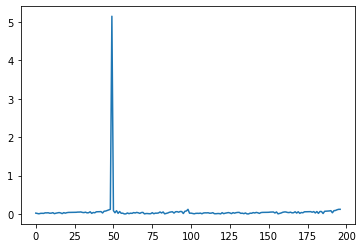

In [10]:
import matplotlib.pyplot as plt

plt.plot(test_model.rmin)

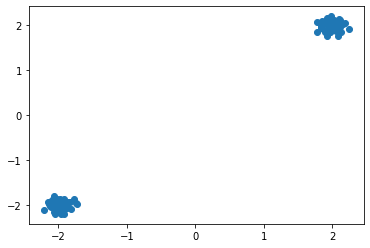

In [11]:
plt.scatter(test_data[:, 0], test_data[:, 1])